# Calcium Imaging Data Exploration in Dandiset 001174

**IMPORTANT:** This notebook was **AI generated using dandi-notebook-gen**. The content has **not been fully verified**. Please exercise caution when interpreting code or results.

This notebook demonstrates:
- How to explore Dandiset metadata
- How to access the NWB files remotely
- Basic visualizations of imaging data and extracted traces
- Insights into segmentation masks of cellular ROIs

---

## About this Dandiset

**Title:** Calcium imaging in SMA and M1 of macaques  
**Description:** Calcium imaging data from projection neurons in supplementary and primary motor areas while macaques were at rest or engaged in reaching tasks. GRIN lenses with GCaMP6f indicators enable recording across behavioral states.  

**DOI:** [https://dandiarchive.org/dandiset/001174/draft](https://dandiarchive.org/dandiset/001174/draft)  
**Keywords:** One-photon imaging, microendoscope, GCaMP, primates, SMA, M1  
**Contributors & Funding:** Galvan et al., supported by NIH and others.  

This dataset contains ~45 NWB files covering multiple animals and sessions.

---

## Setup & Package Imports
Assumes you have all required packages installed: `pynwb`, `lindi`, `matplotlib`, `numpy`, `h5py`, `seaborn`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pynwb
import lindi

sns.set_theme()

## List Assets in the Dandiset
This uses the DANDI API Python client.

In [2]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())
print(f"Found {len(assets)} assets.")
for asset in assets[:5]:
    print(asset.path)
# (Only printing first 5 assets for brevity)

Found 45 assets.
sub-V/sub-V_ses-20230309T110929_ophys.nwb
sub-Q/sub-Q_ophys.nwb
sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
sub-Q/sub-Q_ses-20221028T121142_ophys.nwb


## Load a Representative NWB File
We load an example NWB file (subject `Q`, spontaneous condition).
The NWB file is accessed remotely via the [Lindi](https://lindi.neurosift.org) API which streams the data efficiently.

In [3]:
nwb_url = "https://lindi.neurosift.org/dandi/dandisets/001174/assets/de07db56-e7f3-4809-9972-755c51598e8d/nwb.lindi.json"

f = lindi.LindiH5pyFile.from_lindi_file(nwb_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

print("Session description:", nwb.session_description)
print("Subject ID:", nwb.subject.subject_id)
print("Session start:", nwb.session_start_time)
print("Acquisition types:", list(nwb.acquisition.keys()))
print("Processing modules:", list(nwb.processing.keys()))

Session description: Calcium imaging in SMA during the spontaneous condition
Subject ID: Q
Session start: 2022-09-15 13:16:33.129000+00:00
Acquisition types: ['OnePhotonSeries']
Processing modules: ['ophys']


## Mean Calcium Imaging Frame
We now create a mean projection from a subsample of video frames.
Care is taken to not download and accumulate all frames for efficiency.

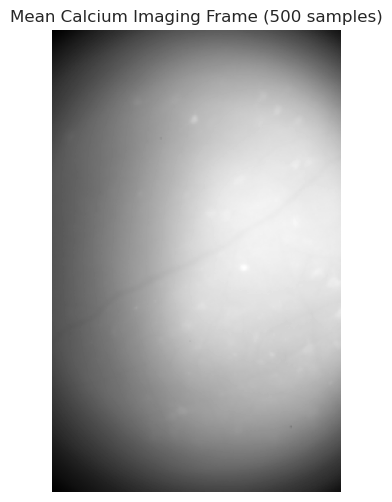

In [4]:
ophys_data = nwb.acquisition['OnePhotonSeries'].data
num_frames = ophys_data.shape[0]
sample_indices = np.linspace(0, num_frames - 1, min(500, num_frames)).astype(int)

mean_frame = np.zeros(ophys_data.shape[1:], dtype=np.float32)
for idx in sample_indices:
    mean_frame += ophys_data[idx, :, :]
mean_frame /= len(sample_indices)

plt.figure(figsize=(6, 6))
plt.imshow(mean_frame, cmap='gray')
plt.title('Mean Calcium Imaging Frame ({} samples)'.format(len(sample_indices)))
plt.axis('off')
plt.show()

The above mean frame shows general spatial features of the imaging FOV during recording. Brightness is highest in the center with visible cell-like features and some vignetting around the edges.

## Calcium Traces Averaged over Cells
Here we inspect the average fluorescence trace over all segmented ROIs to illustrate typical transient dynamics.

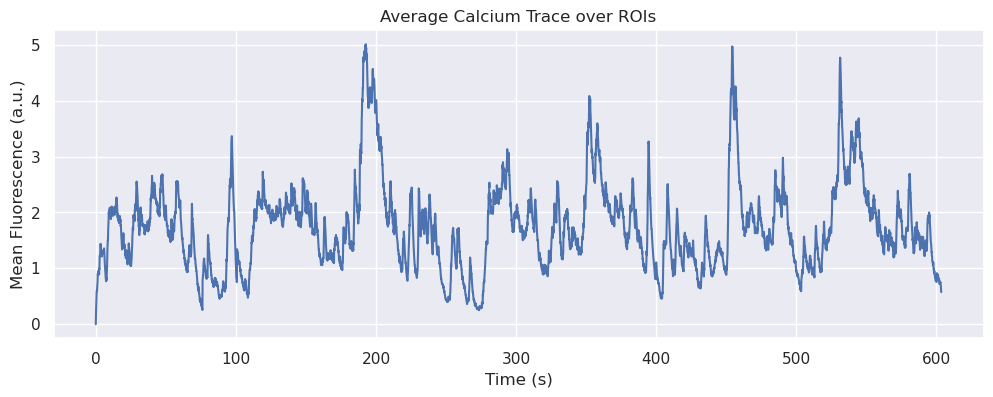

In [5]:
rrs_data = nwb.processing['ophys']['Fluorescence']['RoiResponseSeries'].data
num_timepoints = rrs_data.shape[0]
mean_trace = np.mean(rrs_data[:, :], axis=1)

plt.figure(figsize=(12, 4))
plt.plot(np.arange(num_timepoints)/10.01, mean_trace)
plt.xlabel('Time (s)')
plt.ylabel('Mean Fluorescence (a.u.)')
plt.title('Average Calcium Trace over ROIs')
plt.show()

This plot demonstrates temporal fluctuations and transient peaks in average calcium signals, characteristic of spontaneous neural activity during recording.

## Segmentation Masks of ROIs
We visualize the maximum projection of all segmentation masks to understand the spatial distribution of ROIs (putative cells).

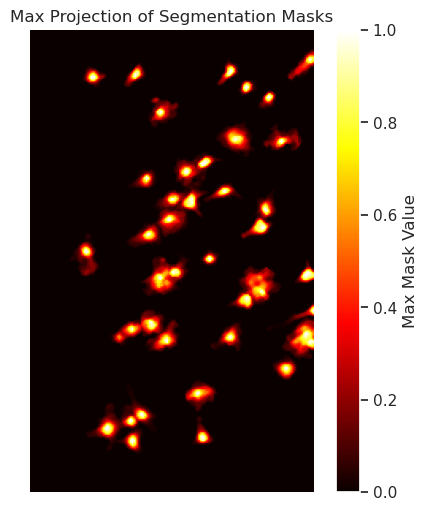

In [6]:
plane_seg = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']
masks = plane_seg['image_mask'].data

max_mask = np.max(masks[:], axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(max_mask, cmap='hot')
plt.colorbar(label='Max Mask Value')
plt.title('Max Projection of Segmentation Masks')
plt.axis('off')
plt.show()

The above heatmap reveals that segmentation detects ~40 cells distributed throughout the imaging plane, mostly well separated, which supports quality extraction of cell-specific signals.

# Summary and Next Steps

This notebook shows how to:
- Access Dandiset 001174 metadata and NWB data remotely
- Visualize example frames, fluorescence dynamics, and ROI masks

**Note:** To draw scientific conclusions, further statistical analyses, appropriate controls, and domain expertise are essential.

**Reminder:** This notebook was autogenerated by AI and has **not undergone full expert review**.